## Importation des bibliothèques

In [239]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MultipleLocator, FuncFormatter

## Chargement et fusion des données

In [240]:
# Lecture des fichiers Excel
file_path = 'sales.xlsx'
xls = pd.ExcelFile(file_path)

# Chargement des feuilles
sales_orders = xls.parse('Sales Orders')
customers = xls.parse('Customers')
regions = xls.parse('Regions')
products = xls.parse('Products')

# Renommage des colonnes pour la fusion
sales_orders.rename(columns={
    'Customer Name Index': 'Customer Index',
    'Delivery Region Index': 'Region Index',
    'Product Description Index': 'Product Index'
}, inplace=True)
regions.rename(columns={'Index': 'Region Index'}, inplace=True)
products.rename(columns={'Index': 'Product Index'}, inplace=True)

# Fusion des données
merged_data = sales_orders.merge(customers, on='Customer Index', how='left')
merged_data = merged_data.merge(regions, on='Region Index', how='left')
merged_data = merged_data.merge(products, on='Product Index', how='left')

# Constantes utilisées dans l'analyse
CY = 2019  # Année en cours
PY = CY - 1  # Année précédente



## Nettoyage des données

In [241]:
# Normalisation des noms de colonnes
merged_data.columns = [col.strip().replace(' ', '_') for col in merged_data.columns]

# Suppression des lignes incomplètes
merged_data_cleaned = merged_data.dropna(subset=['Customer_Names', 'Product_Name', 'Full_Address'])

# Conversion des dates
merged_data_cleaned.rename(columns={'OrderDate': 'Sales_Date'}, inplace=True)
merged_data_cleaned['Sales_Date'] = pd.to_datetime(merged_data_cleaned['Sales_Date'])
merged_data_cleaned['Year'] = merged_data_cleaned['Sales_Date'].dt.year
merged_data_cleaned['Month'] = merged_data_cleaned['Sales_Date'].dt.month


## Calcul des colonnes KPI

In [242]:
# Calculs des ventes, coût et profit
merged_data_cleaned['Total_Sales'] = merged_data_cleaned['Order_Quantity'] * merged_data_cleaned['Unit_Selling_Price']
merged_data_cleaned['Total_Cost'] = merged_data_cleaned['Order_Quantity'] * merged_data_cleaned['Unit_Cost']
merged_data_cleaned['Profit'] = merged_data_cleaned['Total_Sales'] - merged_data_cleaned['Total_Cost']


## Analyse des KPI (par année)

In [243]:
# Création d'un DataFrame des indicateurs annuels
kpi_df = merged_data_cleaned.groupby('Year').agg(
    Total_Sales=('Total_Sales', 'sum'),
    Total_Profit=('Profit', 'sum'),
    Total_Cost=('Total_Cost', 'sum'),
    Total_Order_Quantity=('Order_Quantity', 'sum')
).reset_index()

# Calcul des indicateurs supplémentaires
kpi_df['Total_Sales_PY'] = kpi_df['Total_Sales'].shift(1)
kpi_df['Total_Sales_PY_Var'] = kpi_df['Total_Sales'] - kpi_df['Total_Sales_PY']
kpi_df['Total_Sales_PY_Var_%'] = (kpi_df['Total_Sales_PY_Var'] / kpi_df['Total_Sales']) * 100

kpi_df['Total_Profit_PY'] = kpi_df['Total_Profit'].shift(1)
kpi_df['Total_Profit_PY_Var'] = kpi_df['Total_Profit'] - kpi_df['Total_Profit_PY']
kpi_df['Total_Profit_PY_Var_%'] = (kpi_df['Total_Profit_PY_Var'] / kpi_df['Total_Profit']) * 100
kpi_df['Profit_Margin_%'] = (kpi_df['Total_Profit'] / kpi_df['Total_Sales']) * 100

kpi_df['Total_Order_Quantity_PY'] = kpi_df['Total_Order_Quantity'].shift(1)
kpi_df['Total_Order_Quantity_PY_Var'] = kpi_df['Total_Order_Quantity'] - kpi_df['Total_Order_Quantity_PY']
kpi_df['Total_Order_Quantity_PY_Var_%'] = (kpi_df['Total_Order_Quantity_PY_Var'] / kpi_df['Total_Order_Quantity']) * 100



## Ventes comparaison avec l’année précédente

In [244]:
# Fonction de Création du graphique pour comparaison global
def plot_cy_py_comparison(df, group_by, title="", color="red", figsize=(14, 6)):
    filtered = df[df['Year'].isin([PY, CY])]
    grouped = filtered.groupby([group_by, 'Year'], observed=False)['Total_Sales'].sum().unstack().fillna(0)
    grouped = grouped.sort_values(by=CY, ascending=False)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    sns.barplot(
        x=grouped.index, 
        y=grouped[CY], 
        color=color, 
        edgecolor='none', 
        ax=ax, 
        label='Sales'
    )

    ax.plot(
        range(len(grouped)), 
        grouped[PY], 
        color='black', 
        linestyle='--', 
        linewidth=2, 
        label='Sales PY'
    )
    
    ax.set_title(title, fontsize=14, color='white', pad=15)
    ax.set_ylabel("")
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x / 1_000_000)}M'))
    ax.yaxis.set_major_locator(MultipleLocator(5_000_000))
    
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_color('white')
    ax.tick_params(colors='white')
    
    legend = ax.legend(
        frameon=False,
        loc='best',
        handlelength=1.5,
        handletextpad=0.5,
        borderpad=0.5
    )
    for text in legend.get_texts():
        text.set_color("white")

    fig.patch.set_facecolor('#202a38')
    ax.set_facecolor('#202a38')
    ax.grid(color='white', linestyle='--', linewidth=0.5, axis='y')
    
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_linestyle('dashed')
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['top'].set_linestyle('dashed')
    ax.spines['top'].set_linewidth(0.5)

    if(title == 'Sales CY vs Sales PY by Month'):
        ax.spines['top'].set_color('none')
    
    plt.tight_layout()
    plt.show()

# 1. Par Produits

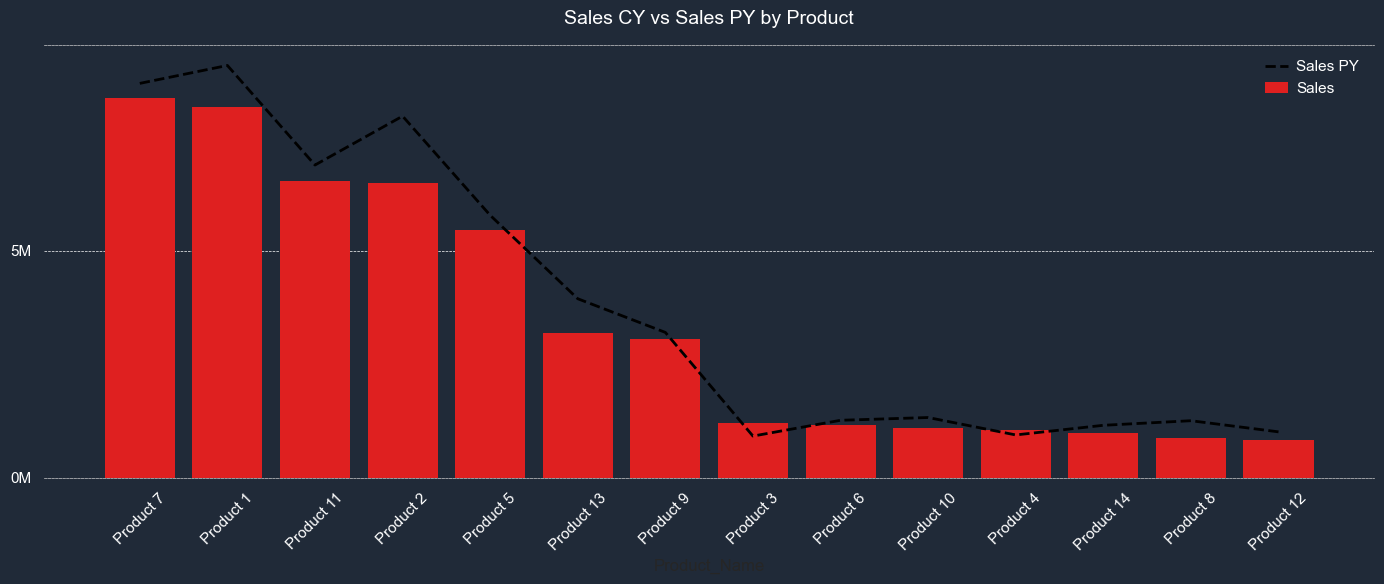

In [245]:
# comparaison par produit
plot_cy_py_comparison(
    df=merged_data_cleaned,
    group_by='Product_Name',
    title='Sales CY vs Sales PY by Product',
    color='red'
)

# 2. Par Mois

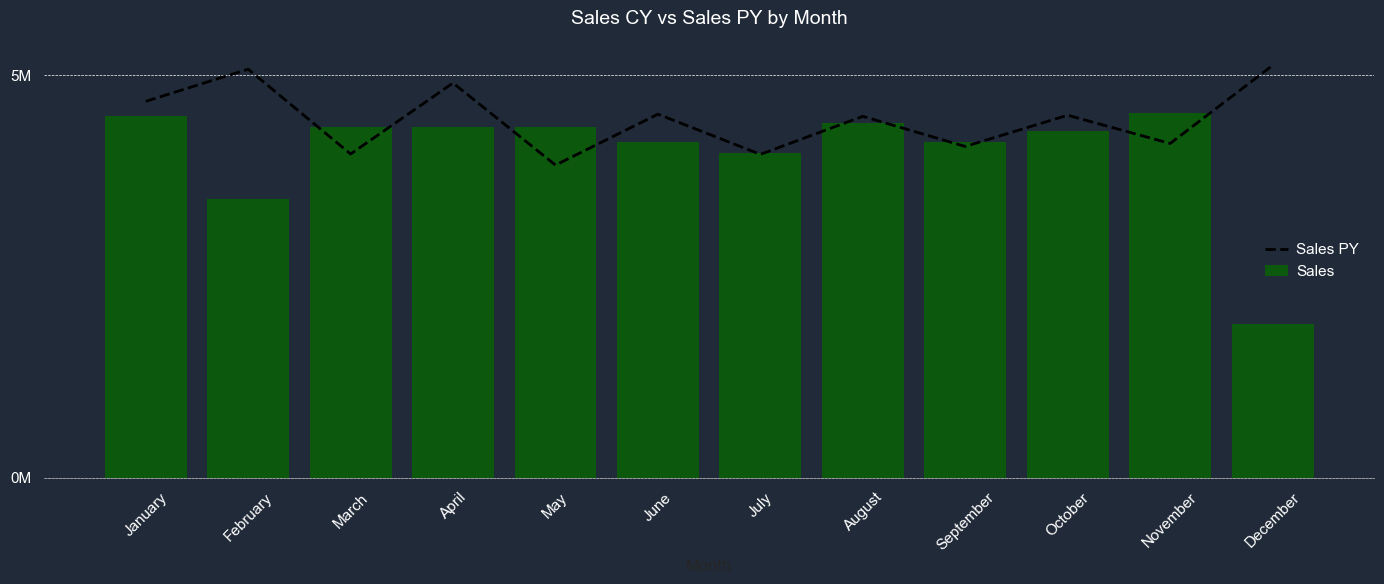

In [246]:
# # comparaison par mois

merged_data_cleaned['Month'] = merged_data_cleaned['Sales_Date'].dt.month_name()
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
merged_data_cleaned['Month'] = pd.Categorical(
    merged_data_cleaned['Month'],
    categories=month_order,
    ordered=True
)

plot_cy_py_comparison(
    df=merged_data_cleaned,
    group_by='Month',
    title='Sales CY vs Sales PY by Month',
    color='darkgreen',
)




## 3. Ventes des 5 premières villes

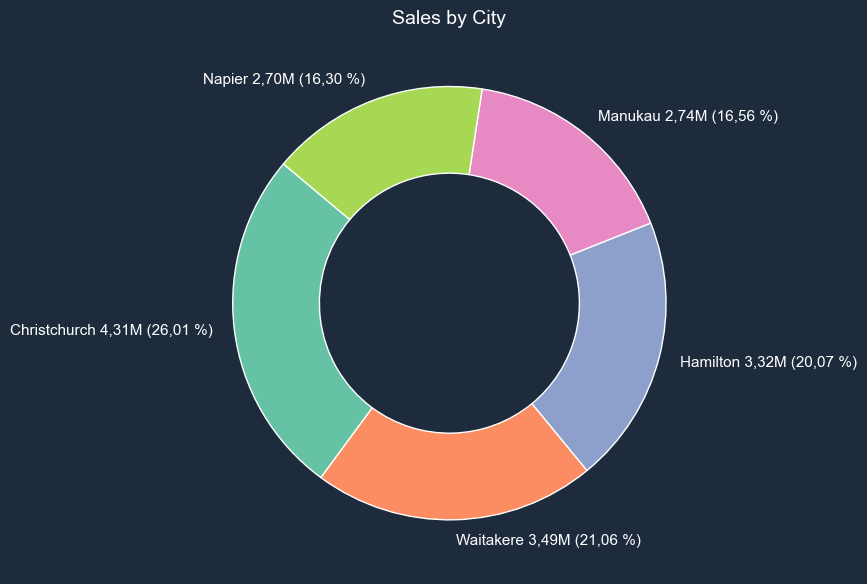

In [247]:
def plot_top_cities_pie(df, title="Sales by City", top_n=5, color_palette="Set2"):
    top_cities = df[df['Year'] == CY].groupby('City')['Total_Sales'].sum().reset_index()
    top_cities = top_cities.sort_values(by='Total_Sales', ascending=False).head(top_n)
    total = top_cities['Total_Sales'].sum()

    def format_millions(value):
        return f"{value / 1_000_000:,.2f}M".replace(".", ",")

    labels = [
        f"{row['City']} {format_millions(row['Total_Sales'])} ({row['Total_Sales'] / total:.2%})".replace(".", ",").replace("%", " %")
        for _, row in top_cities.iterrows()
    ]

    sizes = top_cities['Total_Sales']
    colors = sns.color_palette(color_palette, len(top_cities))

    fig, ax = plt.subplots(figsize=(10, 6), facecolor='#1e2b3c')
    wedges, texts = ax.pie(
        sizes,
        labels=labels,
        startangle=140,
        colors=colors,
        wedgeprops=dict(width=0.4),
        textprops=dict(color='white')
    )

    ax.set_facecolor('#1e2b3c')
    ax.set_title(title, color='white', fontsize=14)
    plt.tight_layout()
    plt.show()

plot_top_cities_pie(merged_data_cleaned)




## 4. Comparaison du bénéfice par canal avec l’année précédente

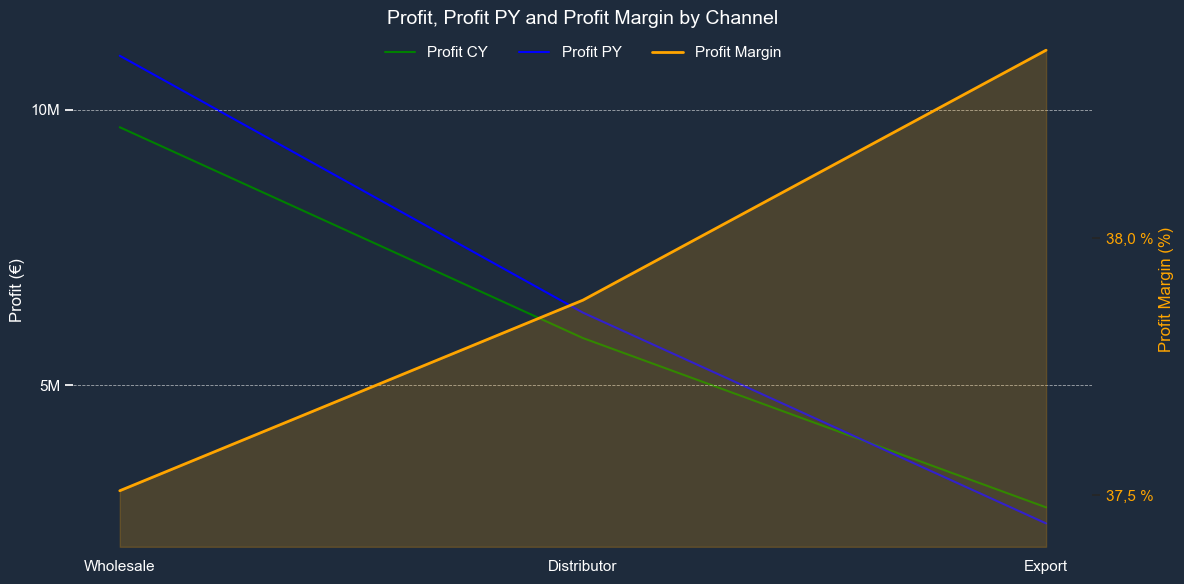

In [248]:
def plot_profit_margin_by_channel(df, title="Profit, Profit PY and Profit Margin by Channel"):

    data = df[df['Year'].isin([PY, CY])].copy()
    grouped = data.groupby(['Channel', 'Year'], observed=False).agg(
        Total_Sales=('Total_Sales', 'sum'),
        Profit=('Profit', 'sum')
    ).reset_index()
    grouped['Profit_Margin'] = grouped['Profit'] / grouped['Total_Sales'] * 100


    profit_pivot = grouped.pivot(index='Channel', columns='Year', values='Profit').fillna(0)
    margin_pivot = grouped[grouped['Year'] == CY].set_index('Channel')['Profit_Margin']
    channels_order = profit_pivot.sort_values(by=CY, ascending=False).index

    profit_cy = profit_pivot.loc[channels_order, CY]
    profit_py = profit_pivot.loc[channels_order, PY]
    margin_cy = margin_pivot.loc[channels_order]
    margin_base = 37.4  

    fig, ax1 = plt.subplots(figsize=(12, 6), facecolor='#1e2b3c')
    ax1.set_facecolor('#1e2b3c')

    ax1.plot(channels_order, profit_cy, color='green', label='Profit CY')
    ax1.plot(channels_order, profit_py, color='blue', label='Profit PY')
    ax1.set_ylabel('Profit (€)', color='white')
    ax1.set_xticks(range(len(channels_order)))
    ax1.set_xticklabels(channels_order, color='white')
    ax1.set_yticks([5_000_000, 10_000_000])
    ax1.set_yticklabels(['5M', '10M'], color='white')
    ax1.tick_params(colors='white')

    for y in [5_000_000, 10_000_000]:
        ax1.axhline(y, color='white', linestyle='--', linewidth=0.6, alpha=0.6)

    ax2 = ax1.twinx()
    ax2.plot(channels_order, margin_cy, color='orange', linewidth=2, label='Profit Margin')
    ax2.fill_between(channels_order, margin_cy, margin_base, color='orange', alpha=0.2)
    ax2.set_ylim(margin_base, 38.4)
    ax2.set_yticks([37.5, 38.0])
    ax2.set_yticklabels(['37,5 %', '38,0 %'], color='orange')
    ax2.set_ylabel('Profit Margin (%)', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    for ax in [ax1, ax2]:
        for spine in ax.spines.values():
            spine.set_visible(False)
    ax1.grid(False)
    ax2.grid(False)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    legend = ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center', bbox_to_anchor=(0.5, 1),ncol = 3, frameon=False)
    for text in legend.get_texts():
        text.set_color('white')

    plt.title(title, color='white', fontsize=14)
    plt.tight_layout()
    plt.show()


plot_profit_margin_by_channel(merged_data_cleaned)


## Ventes comparées par clients

In [249]:
def plot_customer_sales_comparison(df, top=True, title="Sales et Sales PY par Customer Names"):
    customer_data = df[df['Year'].isin([CY, PY])].copy()
    sales_by_customer = customer_data.groupby(['Customer_Names', 'Year'])['Total_Sales'].sum().unstack().fillna(0)
    selected_customers = (
        sales_by_customer.sort_values(by=CY, ascending=False).head(5)
        if top else
        sales_by_customer.sort_values(by=CY, ascending=True).head(5)
    )
    sorted_customers = selected_customers.sort_values(by=CY, ascending=True)
    customers = sorted_customers.index
    x = np.arange(len(customers))
    width = 0.35
    fig, ax = plt.subplots(figsize=(10, 6), facecolor='#1e2b3c')
    ax.set_facecolor('#1e2b3c')
    ax.barh(x - width/2, sorted_customers[PY], height=width, color='black', edgecolor='none' , label=f'Sales PY ({PY})')
    ax.barh(x + width/2, sorted_customers[CY], height=width, color='limegreen',edgecolor='none', label=f'Sales CY ({CY})')
    ax.set_yticks(x)
    ax.set_yticklabels(customers, color='white')
    ax.set_xticks([0, 1_000_000])
    ax.set_xticklabels(['0M', '1M'], color='white')
    for y in [0_000_000, 1_000_000]:
        ax.axvline(y, color='white', linestyle='--', linewidth=0.6, alpha=0.6)
    ax.set_xlabel('Total Sales', color='white')
    ax.set_ylabel('Customer', color='white')
    ax.set_title(title, color='white', fontsize=14)
    ax.tick_params(colors='white')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(False)
    legend = ax.legend(loc='lower right', frameon=False)
    for text in legend.get_texts():
        text.set_color('white')

    plt.tight_layout()
    plt.show()


## 5. Top 5 clients – Ventes comparées

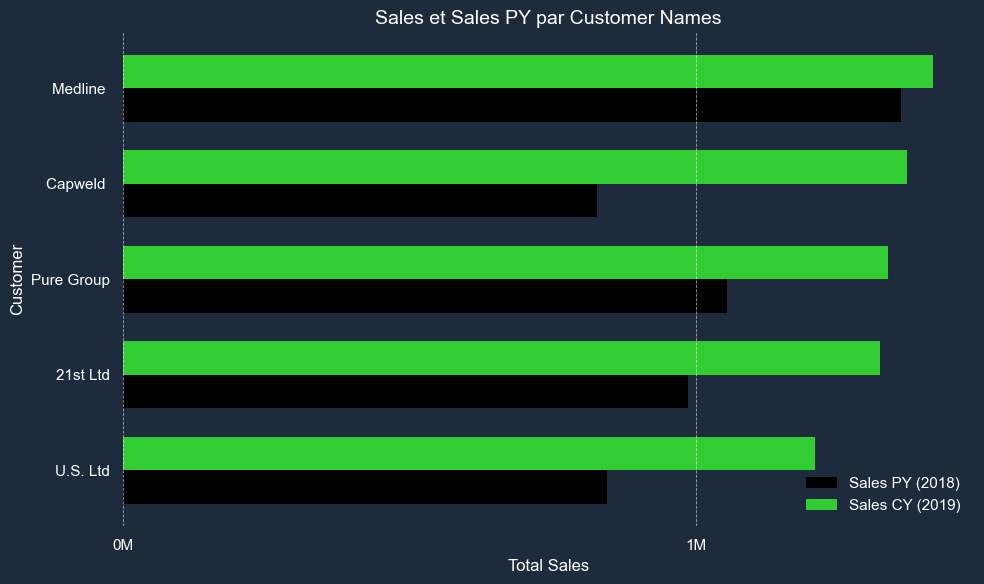

In [250]:
plot_customer_sales_comparison(merged_data_cleaned, top=True)

## 6. Last 5 clients – Ventes comparées

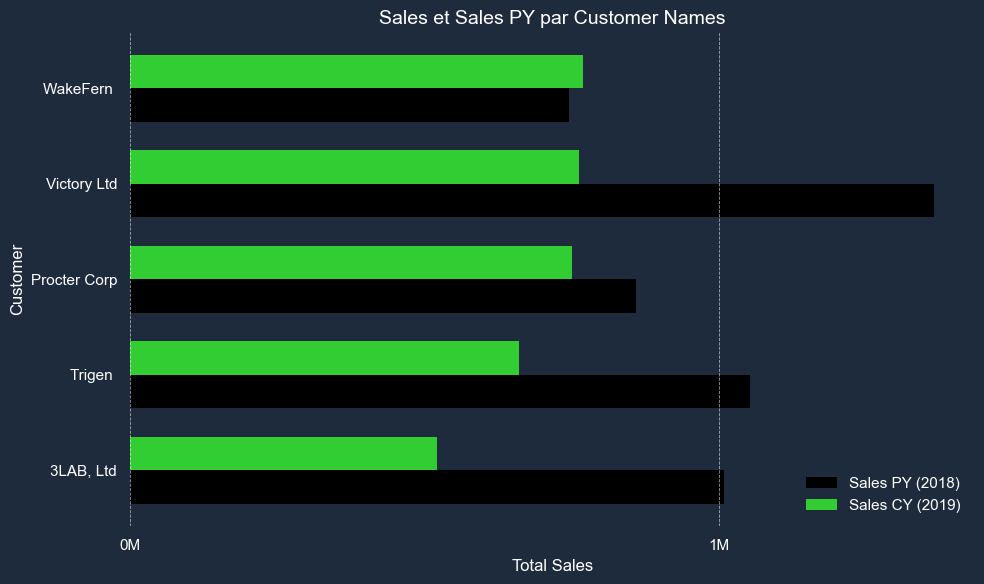

In [251]:
plot_customer_sales_comparison(merged_data_cleaned, top=False)

## 7- Visualisations des KPI (2019)

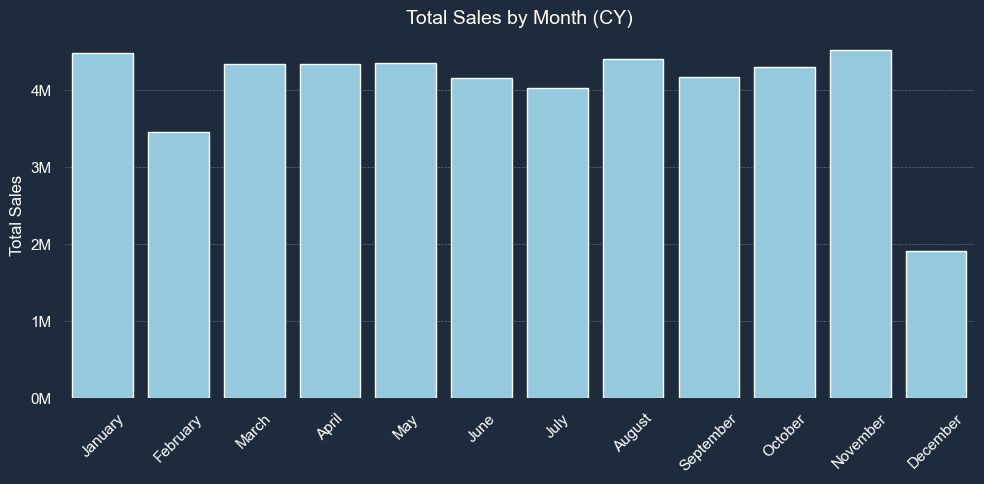

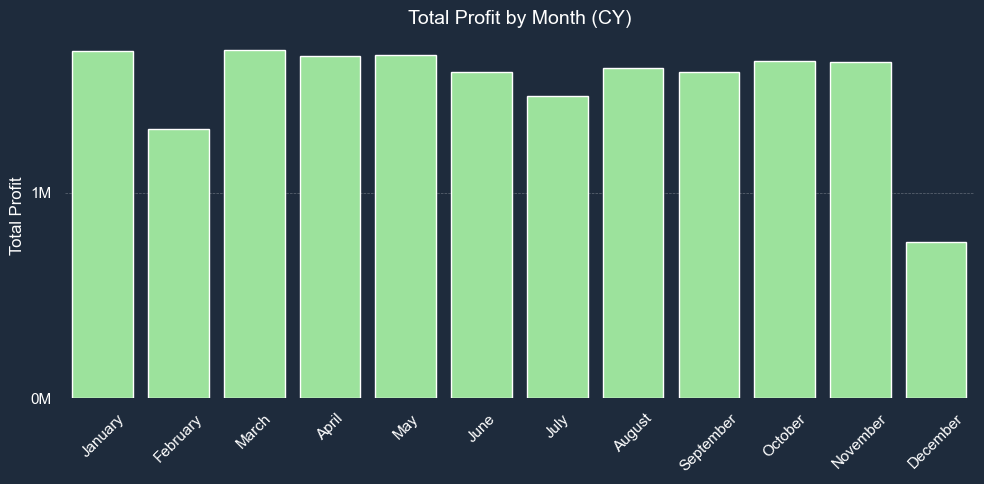

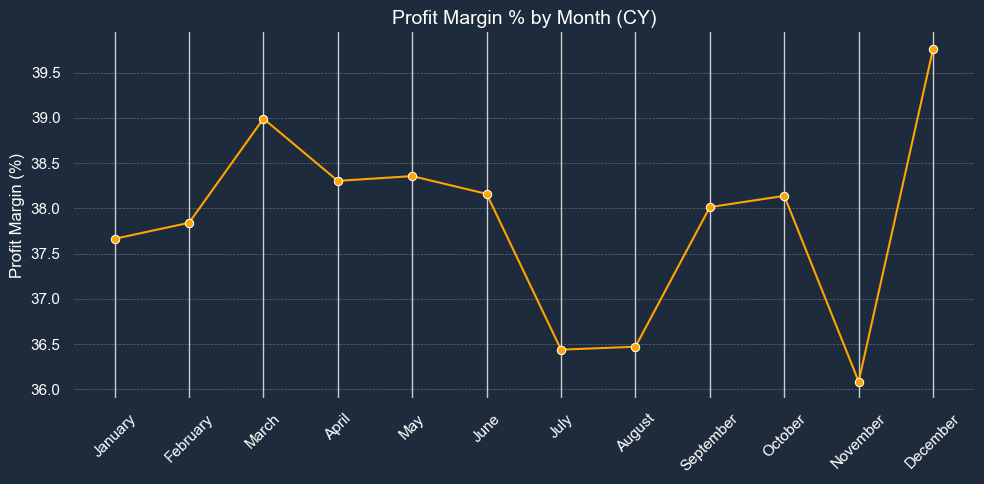

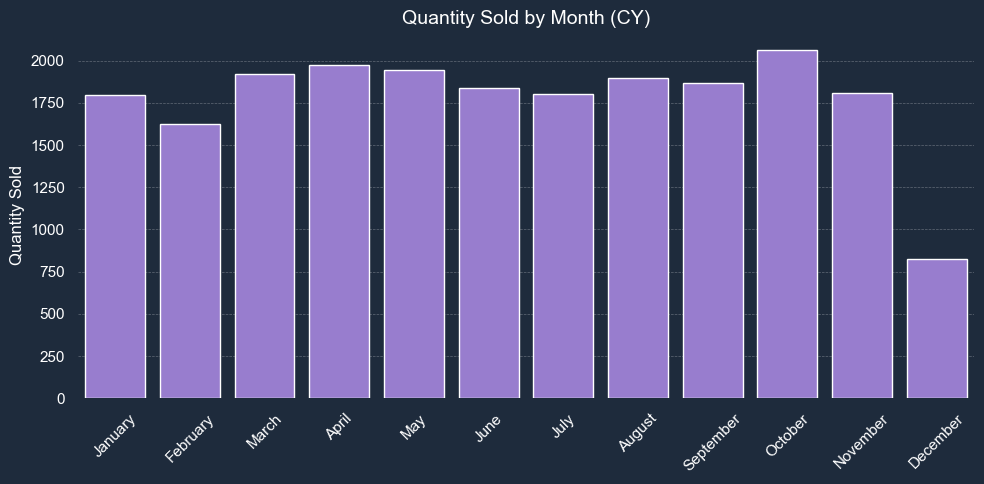

In [252]:
data_cy = merged_data_cleaned[merged_data_cleaned['Year'] == CY].copy()

data_cy['Month'] = data_cy['Sales_Date'].dt.month_name()

monthly_kpis = data_cy.groupby('Month').agg(
    Total_Sales=('Total_Sales', 'sum'),
    Total_Profit=('Profit', 'sum'),
    Quantity_Sold=('Order_Quantity', 'sum')
).reindex(month_order).reset_index()

monthly_kpis['Profit_Margin_%'] = (monthly_kpis['Total_Profit'] / monthly_kpis['Total_Sales']) * 100

def format_dark_chart(ax, title, y_label, y_fmt_millions=True):
    ax.set_facecolor('#1e2b3c')
    ax.set_title(title, color='white', fontsize=14)
    ax.set_xlabel("")
    ax.set_ylabel(y_label, color='white')
    ax.tick_params(colors='white')
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_color('white')
    for label in ax.get_yticklabels():
        label.set_color('white')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(color='white', linestyle='--', linewidth=0.5, axis='y', alpha=0.3)
    if y_fmt_millions:
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x / 1_000_000)}M'))

figures = []

# Visualisation : Ventes mensuelles

fig, ax = plt.subplots(figsize=(10, 5), facecolor='#1e2b3c')
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x / 1_000_000)}M'))
ax.yaxis.set_major_locator(MultipleLocator(1_000_000))
sns.barplot(data=monthly_kpis, x='Month', y='Total_Sales', color='skyblue', ax=ax)
format_dark_chart(ax, 'Total Sales by Month (CY)', 'Total Sales')
fig.tight_layout()
figures.append(fig)

# Visualisation : Bénéfices

fig, ax = plt.subplots(figsize=(10, 5), facecolor='#1e2b3c')
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x / 1_000_000)}M'))
ax.yaxis.set_major_locator(MultipleLocator(1_000_000))
sns.barplot(data=monthly_kpis, x='Month', y='Total_Profit', color='lightgreen', ax=ax)
format_dark_chart(ax, 'Total Profit by Month (CY)', 'Total Profit')
fig.tight_layout()
figures.append(fig)

# Visualisation : Marge bénéficiaire

fig, ax = plt.subplots(figsize=(10, 5), facecolor='#1e2b3c')
sns.lineplot(data=monthly_kpis, x='Month', y='Profit_Margin_%', marker='o', color='orange', ax=ax)
format_dark_chart(ax, 'Profit Margin % by Month (CY)', 'Profit Margin (%)', y_fmt_millions=False)
fig.tight_layout()
figures.append(fig)

# Visualisation : Produits vendus

fig, ax = plt.subplots(figsize=(10, 5), facecolor='#1e2b3c')
sns.barplot(data=monthly_kpis, x='Month', y='Quantity_Sold', color='mediumpurple', ax=ax)
format_dark_chart(ax, 'Quantity Sold by Month (CY)', 'Quantity Sold', y_fmt_millions=False)
fig.tight_layout()
figures.append(fig)
